## Keras

***
My goal is not to fit a good model.
My goal is to show you how to implement what is covered in the slides.
***

#### Table of Contents

- [Preliminaries](#Preliminaries)
- [Null Model](#Null-Model)
- [Initialization](#Initialization)
- [Compilation](#Compilation)
- [Fitting](#Fitting)
- [Evaluation](#Evaluation)
- [Prediction](#Prediction)


****************
# Preliminaries
[TOP](#Keras)

Remember, standardizing your features affects the cost function; standardizing helps correctly and quickly finding the optimal solution.
Let us grab our custom `stdz()` function.

In [1]:
%run metrics.py

Here are the packages and functions that we will need.

In [2]:
# utilties
import numpy as np
import pandas as pd

# processing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# algorithms
from tensorflow import keras

# plotting
from matplotlib import pyplot as plt

# Setting the Seed....

It is quite an involved process. 
Not only do we need to set the seed for `TensorFlow`, but we also need to set it for `NumPy` and in the backend because they are all used when fitting a neural network.

Check out the [documentation](https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development) for more details.

In [3]:
import os
import random
import tensorflow as tf

np.random.seed(490)
os.environ['PYTHONHASSEED'] = '0'
random.seed(490)
tf.random.set_seed(490)

Okay, let's load in our data.

Predicting categorical data requires much more setup than the regression data.

* With continuous labels, you simply proceed as we have been throughout the class up to this point.
- Discrete labels require the data to be transformed via `OneHotEncoder()`

In [4]:
df = pd.read_pickle('C:/Users/hubst/Econ490_group/class_data.pkl')

In [5]:
df_prepped = df.drop(columns = ['year', 'GeoName']).join([
    pd.get_dummies(df['year'], drop_first = True)
])

In [6]:
y = df_prepped['urate_bin']
x = df_prepped.drop(columns = 'urate_bin')

This is a step-by-step how to prepare categorical data for `OneHotEncoder()`.

In [7]:
ohe = OneHotEncoder().fit(np.array(y).reshape(-1, 1))

Okay, time to split the data.

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                   train_size = 2/3,
                                                   random_state = 490)

x_train = x_train.apply(stdz)
x_test = x_test.apply(stdz)

y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

y_train = ohe.transform(y_train).toarray()
y_test = ohe.transform(y_test).toarray()

Just to reiterate how we have transformed our label:

In [9]:
y_train[0:5, :]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.]])

***********
# Null Model
[TOP](#Keras)

We are going to have to fit the null model differently than before because it is now an `np.array()`, not a `pd.Series()`.

In [10]:
y_train_counts = y_train.sum(axis = 0)
yhat_null = np.argmax(y_train_counts)

acc_null = y_test[:, yhat_null].sum()/y_test.sum()
acc_null

0.4348554671135316

*****************
# Initialization
[TOP](#Keras)

I would not recommend actually fitting this model.
This is purely for expositional purposes.

I am going to show you how to add activation functions in multiple ways:

In [11]:
from tensorflow.keras.layers import LeakyReLU

Let's determine our input and output `shape`.

In [12]:
x_train.shape

(33418, 26)

In [13]:
y_train.shape

(33418, 3)

Okay, let's define our first neural network!

In [14]:
model = keras.models.Sequential()
model.add(keras.layers.Input(shape = x_train.shape[1]))
model.add(keras.layers.Dense(300, activation = 'relu'))
model.add(keras.layers.Dense(200, activation = LeakyReLU(alpha = 0.1)))
model.add(keras.layers.Dense(100, activation = 'elu'))
model.add(keras.layers.Dense(100, activation = keras.layers.ELU(alpha = 0.1)))
model.add(keras.layers.Dense(y_train.shape[1], activation = 'softmax'))

Want to see something crazy?

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               8100      
_________________________________________________________________
dense_1 (Dense)              (None, 200)               60200     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 303       
Total params: 98,803
Trainable params: 98,803
Non-trainable params: 0
_________________________________________________________________


Holy parameters, Batman!

Let's see how we got so many:

In [16]:
# Dense
(1 + x_train.shape[1])*300

8100

In [17]:
# dense_1
(1 + 300)*200

60200

In [18]:
# dense_2
(1 + 200)*100

20100

In [19]:
# dense_3
(1 + 100)*100

10100

In [20]:
(1 + 100)*y_train.shape[1]

303

Here is an alternative way to define a sequential NN:

In [21]:
model2 = keras.models.Sequential([
    keras.layers.Input(shape = x_train.shape[1]),
    keras.layers.Dense(300, activation = 'relu'),
    keras.layers.Dense(200, activation = LeakyReLU(alpha = 0.1)),
    keras.layers.Dense(100, activation = 'elu'),
    keras.layers.Dense(100, activation = keras.layers.ELU(alpha = 0.1)),
    keras.layers.Dense(y_train.shape[1], activation = 'softmax')
])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 300)               8100      
_________________________________________________________________
dense_6 (Dense)              (None, 200)               60200     
_________________________________________________________________
dense_7 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_8 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 303       
Total params: 98,803
Trainable params: 98,803
Non-trainable params: 0
_________________________________________________________________


*********************
# Compilation
[TOP](#Keras)

I am going to show you three different ways to compile the model:

1. the easy way
2. with a custom optimizer
3. with a custom optimizer and custom learning rate

The easy way:

In [22]:
model.compile(loss = 'categorical_crossentropy',
             metrics = ['accuracy', 'categorical_crossentropy'],
             optimizer = 'rmsprop')

Custom optimizer:

In [23]:
model.compile(loss = 'categorical_crossentropy',
             metrics = ['accuracy'],
             optimizer = keras.optimizers.RMSprop(learning_rate = 0.001,
                                                 rho = 0.9,
                                                 momentum = 0.0,
                                                 epsilon = 1e-7))

Now we shall fit a custom learning rate schedule.
The default values for an exponential decay learning schedule is too extreme for our setting.
We are going to do some math to adjust the default values.

When we fit, we will have:

- all the training data over batches of size 32 (the default)
- 20% validation_fraction
- 30 epochs

In [24]:
x_train.shape[0]/32*(1 - 0.2)*30

25063.5

In [25]:
lr_exp = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.1,
    decay_steps = 100000,
    decay_rate = 0.96)
lr_exp = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.1,
    decay_steps = 5000,
    decay_rate = 0.3)

In [26]:
model.compile(loss = 'categorical_crossentropy',
             metrics = ['accuracy'],
             optimizer = keras.optimizers.RMSprop(learning_rate = 0.001,
                                                 rho = 0.9,
                                                 momentum = 0.0,
                                                 epsilon = 1e-7))

*********
# Fitting 
[TOP](#Keras)

Before we can fit our final model, we will set up early stopping.
This is the same idea as in boosting ensembles.

In [27]:
es = keras.callbacks.EarlyStopping(patience = 4)

Here we go!

In [28]:
history = model.fit(x_train, y_train,
                   batch_size = 32,
                   epochs = 30,
                   validation_split = 0.2,
                   callbacks = [es])

Epoch 1/30
836/836 [==============================] - 3s 3ms/step - loss: 0.7862 - accuracy: 0.6514 - val_loss: 0.7197 - val_accuracy: 0.6779
Epoch 2/30
836/836 [==============================] - 1s 2ms/step - loss: 0.7283 - accuracy: 0.6769 - val_loss: 0.7255 - val_accuracy: 0.6801
Epoch 3/30
836/836 [==============================] - 1s 2ms/step - loss: 0.7213 - accuracy: 0.6849 - val_loss: 0.7233 - val_accuracy: 0.6807
Epoch 4/30
836/836 [==============================] - 1s 2ms/step - loss: 0.7124 - accuracy: 0.6878 - val_loss: 0.7087 - val_accuracy: 0.6918
Epoch 5/30
836/836 [==============================] - 1s 2ms/step - loss: 0.7012 - accuracy: 0.6903 - val_loss: 0.7222 - val_accuracy: 0.6812
Epoch 6/30
836/836 [==============================] - 2s 2ms/step - loss: 0.6943 - accuracy: 0.6982 - val_loss: 0.7169 - val_accuracy: 0.6955
Epoch 7/30
836/836 [==============================] - 1s 2ms/step - loss: 0.6834 - accuracy: 0.7023 - val_loss: 0.7010 - val_accuracy: 0.6940
Epoch 

We can take a look at the performance of training over time:

In [29]:
history.history
train_results = pd.DataFrame(history.history)
train_results.head()

,loss,accuracy,val_loss,val_accuracy
0,0.759255,0.663537,0.719708,0.677887
1,0.729486,0.675918,0.725477,0.680132
2,0.717844,0.682464,0.723344,0.680730
3,0.710579,0.687813,0.708671,0.691801
4,0.703837,0.690881,0.722204,0.681179


And plot it!

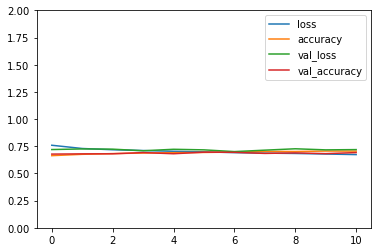

In [30]:
train_results.plot()

plt.ylim(0, 2)
plt.grid =(True)

plt.show()

***************
# Evaluation
[TOP](#Keras)

Evaluation is perhaps one of the easiest parts:

In [31]:
model_perf = model.evaluate(x_test, y_test)
model_perf

523/523 [==============================] - 0s 742us/step - loss: 0.7302 - accuracy: 0.6886


[0.7301988005638123, 0.6885510683059692]

Let's save our accuracy

In [32]:
acc_nn = model_perf[1]
acc_nn

0.6885510683059692

Yikes.
What was the null accuracy again?

In [33]:
acc_null

0.4348554671135316

What was the percetage point gain from the null model?

In [34]:
acc_nn - acc_null

0.2536956011924376

Well... at least it is positive...

****************
# Prediction
[TOP](#Keras)

And now for some fancy prediction

In [35]:
yhat = model.predict(x_test.iloc[0:5, :])
yhat
np.argmax(yhat, axis = 1)

array([1, 0, 1, 0, 1], dtype=int64)